# **Prova 1 | CEP**

Camila de Araújo Valença, 202014548

Dataset: AI4I 2020 Predictive Maintenance Dataset

### **Passo 1 – Importação de Bibliotecas**

Foram importadas as bibliotecas necessárias para a execução das análises estatísticas e geração dos gráficos.

* **pandas (pd):** utilizada para manipulação e organização dos dados em formato tabular, facilitando os cálculos e a estruturação das amostras.
* **numpy (np):** empregada para a realização de operações matemáticas e numéricas com eficiência e precisão.
* **matplotlib.pyplot (plt):** responsável pela criação das cartas de controle e demais visualizações gráficas.
* **os:** Para interagir com o sistema operacional (verificar arquivos).
* **textwrap:** Usado para formatar o texto de saída.

A importação dessas bibliotecas foi fundamental para disponibilizar os recursos necessários ao Controle Estatístico de Processos (CEP), permitindo análises estruturadas e visualmente interpretáveis.

In [1]:
# =========================================================
# Passo 1: Importação de Bibliotecas (pd, np, plt)
# =========================================================
import os
import textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Definição dos parâmetros globais (usados nos passos seguintes) ---
CSV_PATH = "(dataset)CamilaValenca_CEP_Prova.csv"  # <-- Verifique se o nome está correto após upload!
VARIAVEL = "Torque [Nm]"
N = 5
K = 25
A2 = 0.577
D3 = 0.0
D4 = 2.114
LIE = None # Defina se tiver (ex: 35.0)
LSE = None # Defina se tiver (ex: 45.0)

# --- Função utilitária para checagens ---
def _assert(cond, msg):
    """Utilitário simples para checagens e mensagens."""
    if not cond:
        raise AssertionError(msg)

print(">>> Bibliotecas importadas e parâmetros definidos.")

>>> Bibliotecas importadas e parâmetros definidos.


### **Passo 2 – Carregamento dos Dados**

O arquivo **CSV** contendo as medições (neste caso, `(dataset)CamilaValenca_CEP_Prova.csv` com a variável `Torque [Nm]`) foi carregado para o ambiente de análise utilizando o **pandas**. Esse procedimento teve como objetivo converter os dados em um formato estruturado (DataFrame), adequado para manipulação e cálculo.

Após o carregamento, foi realizada a verificação das primeiras linhas e das dimensões do *dataset* para confirmar a leitura correta. Também foi verificada a existência de valores ausentes (`dropna()`) e a adequação dos tipos de dados numéricos. O código seleciona as primeiras `N * K` (5 * 25 = 125) observações válidas da variável de interesse para formar as amostras.

In [2]:
# =========================================================
# Passo 2: Carregamento dos Dados
# =========================================================
print(f">>> Carregando o CSV: {CSV_PATH}")

# Verifica se o arquivo existe no ambiente Colab
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"Arquivo '{CSV_PATH}' não encontrado. Faça o upload para o Colab.")

_df_original = pd.read_csv(CSV_PATH)

print("\nPrimeiras linhas do dataset original:")
print(_df_original.head())
print(f"\nDimensões do dataset original (linhas, colunas): {_df_original.shape}")

# Ordena por UDI se existir para manter sequência de produção (se aplicável ao seu CSV original)
if "UDI" in _df_original.columns:
    _df_sorted = _df_original.sort_values("UDI").reset_index(drop=True)
else:
    _df_sorted = _df_original # Assume que já está na ordem correta

# Checa se a variável existe
_assert(VARIAVEL in _df_sorted.columns,
        f'A coluna "{VARIAVEL}" não existe no CSV. Colunas disponíveis: {list(_df_sorted.columns)}')

# Seleciona somente a variável de interesse e remove valores ausentes (NaN)
df_variavel = _df_sorted[[VARIAVEL]].dropna().reset_index(drop=True)
print(f"\nNúmero de observações válidas encontradas para '{VARIAVEL}': {len(df_variavel)}")

# Checa se há dados suficientes para K amostras de N
total_necessario = N * K
_assert(len(df_variavel) >= total_necessario,
        f"Só há {len(df_variavel)} observações válidas; são necessárias {total_necessario} ({K} amostras de {N}).")

# Mantém apenas as primeiras K*N observações necessárias
df_amostras = df_variavel.iloc[:total_necessario].copy()
print(f"Utilizando as primeiras {total_necessario} observações para formar {K} amostras de tamanho {N}.")

>>> Carregando o CSV: (dataset)CamilaValenca_CEP_Prova.csv

Primeiras linhas do dataset original:
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9         

### **Passo 3 – Cálculo das Estatísticas por Amostra**

Foram calculadas as principais estatísticas descritivas para cada uma das 25 amostras (subgrupos de tamanho n=5), resumindo o comportamento interno de cada subgrupo.

* A **média amostral ($\bar{X}$ - `xbar`)** foi determinada para representar a tendência central de cada conjunto de 5 medições.
* A **amplitude ($\textit{R}$ - `r`)** foi obtida pela diferença entre o maior e o menor valor da amostra, representando sua variabilidade interna.

Essas estatísticas foram armazenadas em um novo DataFrame (`resumo`) e serviram de base para a construção das Cartas $\bar{X}$ e R.

In [3]:
# =========================================================
# Passo 3: Cálculo das Estatísticas por Amostra (X̄ e R)
# =========================================================
# Adiciona coluna para identificar a amostra (1 a K)
df_amostras["amostra"] = np.repeat(np.arange(1, K + 1), N)

# Calcula X-barra (média) e R (amplitude) para cada amostra
resumo_amostras = (
    df_amostras.groupby("amostra")[VARIAVEL]
               .agg(xbar="mean", r=lambda s: s.max() - s.min(), n="count")
               .reset_index()
)

# Verifica se todos os grupos têm o tamanho esperado N
_assert(resumo_amostras["n"].eq(N).all(), "Erro interno: Alguma amostra não tem exatamente n=5 observações.")

print("\nResumo das estatísticas calculadas (X̄ e R) para as 5 primeiras amostras:")
print(resumo_amostras.head())


Resumo das estatísticas calculadas (X̄ e R) para as 5 primeiras amostras:
   amostra   xbar     r  n
0        1  43.60   9.9  5
1        2  36.22  14.4  5
2        3  33.78  31.5  5
3        4  45.52  22.0  5
4        5  36.24  19.1  5


### **Passo 4 – Cálculo dos Limites de Controle para a Carta $\bar{X}$**

Nesta etapa foram determinados os parâmetros da Carta $\bar{X}$, responsável por monitorar a **tendência central do processo**.
Foram calculados:

* **Média das médias ($\bar{\bar{X}}$ - `xbarbar`):** média aritmética de todas as 25 médias amostrais.
* **Amplitude média ($\bar{R}$ - `rbar`):** média das 25 amplitudes amostrais.
* **Limites de Controle:**
    * LSC = $\bar{\bar{X}} + A_2 \times \bar{R}$
    * LIC = $\bar{\bar{X}} - A_2 \times \bar{R}$
    * LC = $\bar{\bar{X}}$
    A constante $A_2 = 0.577$ (para n = 5) foi utilizada.

### **Passo 5 – Cálculo dos Limites de Controle para a Carta R**

Foram calculados os limites da Carta R, utilizada para monitorar a **variabilidade do processo**. Os parâmetros foram determinados pelas expressões:

* LSC = $D_4 \times \bar{R}$
* LIC = $D_3 \times \bar{R}$
* LC = $\bar{R}$
    Para subgrupos de tamanho n = 5, as constantes empregadas foram $D_3 = 0$ e $D_4 = 2.114$. O limite inferior resultou em zero.

In [4]:
# =========================================================
# Passos 4 e 5: Cálculo dos Limites de Controle (X̄ e R)
# =========================================================
# Calcula a média das médias (X-bar-bar) e a amplitude média (R-bar)
xbarbar = resumo_amostras["xbar"].mean()
rbar = resumo_amostras["r"].mean()

# Calcula Limites para a Carta X̄
xbar_LC = xbarbar
xbar_LSC = xbarbar + A2 * rbar
xbar_LIC = xbarbar - A2 * rbar

# Calcula Limites para a Carta R
r_LC = rbar
r_LSC = D4 * rbar
r_LIC = D3 * rbar # Para n=5, D3=0, então LIC será 0

print("\nParâmetros globais calculados:")
print(f"X̄̄ (Média das médias) = {xbarbar:.6f}")
print(f"R̄ (Amplitude média)  = {rbar:.6f}")
print(f"\nParâmetros da Carta X̄:")
print(f"  LSC = {xbar_LSC:.6f}")
print(f"  LC  = {xbar_LC:.6f}")
print(f"  LIC = {xbar_LIC:.6f}")
print(f"\nParâmetros da Carta R:")
print(f"  LSC = {r_LSC:.6f}")
print(f"  LC  = {r_LC:.6f}")
print(f"  LIC = {r_LIC:.6f}")


Parâmetros globais calculados:
X̄̄ (Média das médias) = 39.056000
R̄ (Amplitude média)  = 21.476000

Parâmetros da Carta X̄:
  LSC = 51.447652
  LC  = 39.056000
  LIC = 26.664348

Parâmetros da Carta R:
  LSC = 45.400264
  LC  = 21.476000
  LIC = 0.000000


### **Passo 6 – Construção da Carta $\bar{X}$**

A Carta $\bar{X}$ foi construída para representar graficamente o comportamento das médias amostrais ($\bar{X}$) ao longo das 25 amostras. O gráfico inclui:

* Pontos conectados representando as médias de cada amostra.
* Linhas horizontais para a Linha Central (LC), Limite Superior de Controle (LSC) e Limite Inferior de Controle (LIC).
* (Opcional) Linhas pontilhadas para Limites de Especificação (LIE e LSE), se definidos.

O gráfico é salvo como arquivo `.png` e também exibido abaixo.


>>> Gráfico X̄ salvo como 'carta_xbar_CamilaValenca_CEP_Prova.png'


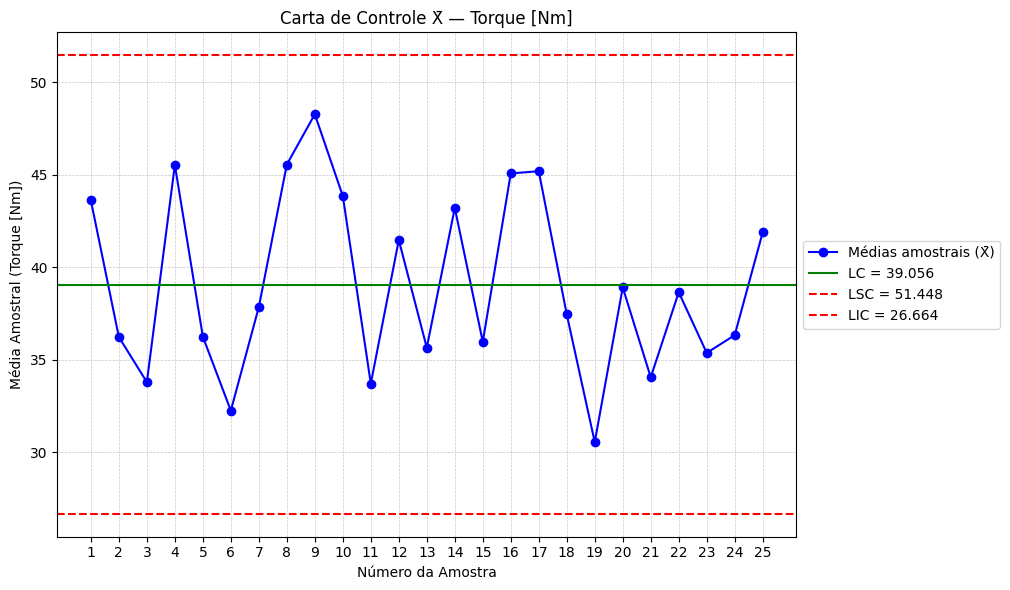

In [5]:
# =========================================================
# Passo 6: Construção da Carta X̄
# =========================================================
amostras_idx = resumo_amostras["amostra"].values
xbar_valores = resumo_amostras["xbar"].values

plt.figure(figsize=(12, 6)) # Tamanho do gráfico
plt.plot(amostras_idx, xbar_valores, marker="o", linestyle="-", color="blue", label="Médias amostrais (X̄)")

# Linhas de controle
plt.axhline(xbar_LC,  color="green", linestyle="-",  label=f"LC = {xbar_LC:.3f}")
plt.axhline(xbar_LSC, color="red",   linestyle="--", label=f"LSC = {xbar_LSC:.3f}")
plt.axhline(xbar_LIC, color="red",   linestyle="--", label=f"LIC = {xbar_LIC:.3f}")

# Linhas de especificação (opcional)
if LIE is not None:
    plt.axhline(LIE, color="orange", linestyle=":", label=f"LIE = {LIE}")
if LSE is not None:
    plt.axhline(LSE, color="orange", linestyle=":", label=f"LSE = {LSE}")

# Títulos e rótulos
plt.title(f"Carta de Controle X̄ — {VARIAVEL}")
plt.xlabel("Número da Amostra")
plt.ylabel(f"Média Amostral ({VARIAVEL})")
plt.xticks(np.arange(1, K + 1)) # Garante que todos os números de amostra apareçam no eixo x
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7) # Grade
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Legenda fora do gráfico
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajusta layout para caber a legenda

# Salva e mostra o gráfico
plt.savefig("carta_xbar_CamilaValenca_CEP_Prova.png", dpi=150, bbox_inches='tight')
print("\n>>> Gráfico X̄ salvo como 'carta_xbar_CamilaValenca_CEP_Prova.png'")
plt.show() # Mostra o gráfico no Colab

### **Passo 7 – Construção da Carta R**

Foi elaborada a Carta R para representar graficamente a variação interna das amostras (Amplitude, R). O gráfico apresenta:

* Pontos conectados representando as amplitudes (R) de cada amostra.
* Linhas horizontais para a Linha Central (LC), Limite Superior de Controle (LSC) e Limite Inferior (LIC = 0 para n=5).

O gráfico é salvo como arquivo `.png` e também exibido abaixo.


>>> Gráfico R salvo como 'carta_r_CamilaValenca_CEP_Prova.png'


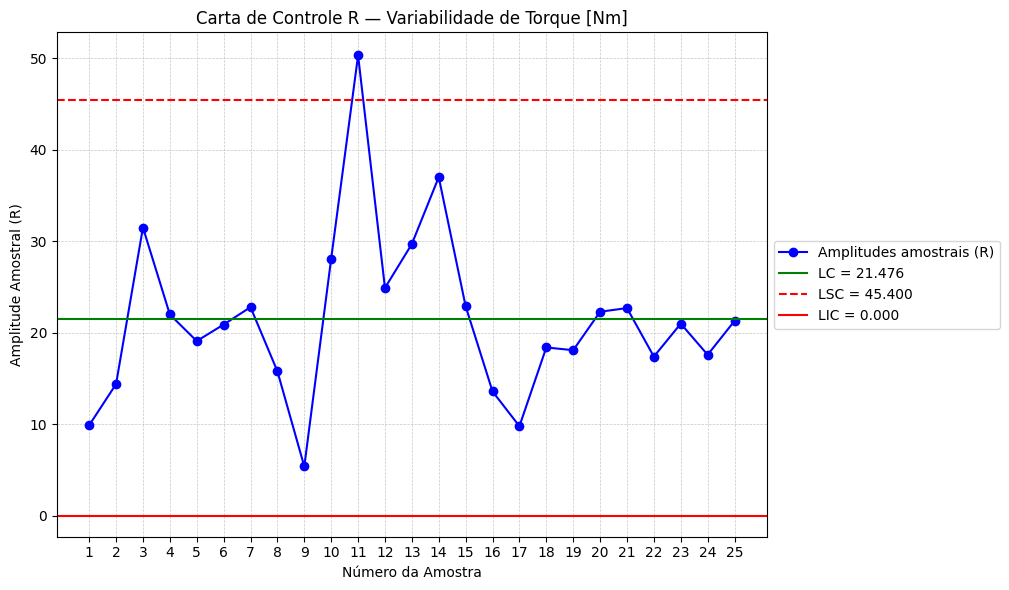

In [6]:
# =========================================================
# Passo 7: Construção da Carta R
# =========================================================
r_valores = resumo_amostras["r"].values

plt.figure(figsize=(12, 6)) # Tamanho do gráfico
plt.plot(amostras_idx, r_valores, marker="o", linestyle="-", color="blue", label="Amplitudes amostrais (R)")

# Linhas de controle
plt.axhline(r_LC,  color="green", linestyle="-",  label=f"LC = {r_LC:.3f}")
plt.axhline(r_LSC, color="red",   linestyle="--", label=f"LSC = {r_LSC:.3f}")
plt.axhline(r_LIC, color="red",   linestyle="-",  label=f"LIC = {r_LIC:.3f}") # LIC é 0 para n=5

# Títulos e rótulos
plt.title(f"Carta de Controle R — Variabilidade de {VARIAVEL}")
plt.xlabel("Número da Amostra")
plt.ylabel("Amplitude Amostral (R)")
plt.xticks(np.arange(1, K + 1)) # Garante que todos os números de amostra apareçam
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7) # Grade

# Ajusta limite inferior do eixo y para melhor visualização, se LIC=0
if r_LIC == 0:
    plt.ylim(bottom=-0.05 * r_LSC) # Um pouco abaixo de zero

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Legenda fora do gráfico
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajusta layout para caber a legenda

# Salva e mostra o gráfico
plt.savefig("carta_r_CamilaValenca_CEP_Prova.png", dpi=150, bbox_inches='tight')
print("\n>>> Gráfico R salvo como 'carta_r_CamilaValenca_CEP_Prova.png'")
plt.show() # Mostra o gráfico no Colab

### **Passo 8 – Análise de Pontos Fora de Controle**

Foram identificadas sistematicamente as amostras cujos valores de $\bar{X}$ ou R caíram fora dos respectivos limites de controle calculados.

* Na **Carta $\bar{X}$**, buscou-se por $\bar{X} > LSC$ ou $\bar{X} < LIC$.
* Na **Carta R**, buscou-se por $R > LSC$.

Os resultados são exibidos abaixo e as estatísticas de todas as amostras foram salvas em um arquivo CSV.

In [7]:
# =========================================================
# Passo 8: Análise de Pontos Fora de Controle
# =========================================================
# Identifica os pontos fora dos limites
fora_x_acima  = resumo_amostras[resumo_amostras["xbar"] > xbar_LSC][["amostra", "xbar"]].copy()
fora_x_abaixo = resumo_amostras[resumo_amostras["xbar"] < xbar_LIC][["amostra", "xbar"]].copy()
fora_r_acima  = resumo_amostras[resumo_amostras["r"]   > r_LSC][["amostra", "r"]].copy()
fora_r_abaixo = resumo_amostras[resumo_amostras["r"]   < r_LIC][["amostra", "r"]].copy() # Geralmente vazio se LIC=0

# Salva o resumo Xbar e R por amostra em CSV
output_csv_resumo = "xbar_r_por_amostra_CamilaValenca_CEP_Prova.csv"
resumo_amostras.to_csv(output_csv_resumo, index=False, encoding="utf-8", float_format='%.6f')
print(f"\nResumo X̄ e R por amostra salvo em: {output_csv_resumo}")

# Imprime os resultados da análise
print("\n--- Pontos Fora de Controle ---")
print("\nCarta X̄ (Médias acima do LSC):")
print(fora_x_acima.to_string(index=False) if not fora_x_acima.empty else "Nenhum.")
print("\nCarta X̄ (Médias abaixo do LIC):")
print(fora_x_abaixo.to_string(index=False) if not fora_x_abaixo.empty else "Nenhum.")
print("\nCarta R (Amplitudes acima do LSC):")
print(fora_r_acima.to_string(index=False) if not fora_r_acima.empty else "Nenhum.")

if r_LIC > 0: # Só mostra se LIC for maior que zero
    print("\nCarta R (Amplitudes abaixo do LIC):")
    print(fora_r_abaixo.to_string(index=False) if not fora_r_abaixo.empty else "Nenhum.")
else:
     print("\nCarta R (Amplitudes abaixo do LIC = 0):")
     print("Nenhum ponto pode estar abaixo de zero.")
print("-------------------------------")


Resumo X̄ e R por amostra salvo em: xbar_r_por_amostra_CamilaValenca_CEP_Prova.csv

--- Pontos Fora de Controle ---

Carta X̄ (Médias acima do LSC):
Nenhum.

Carta X̄ (Médias abaixo do LIC):
Nenhum.

Carta R (Amplitudes acima do LSC):
 amostra    r
      11 50.3

Carta R (Amplitudes abaixo do LIC = 0):
Nenhum ponto pode estar abaixo de zero.
-------------------------------


### **Passo 9 – Interpretação dos Resultados**

Os resultados das cartas de controle foram interpretados para avaliar a condição estatística do processo de medição de Torque. A análise verifica:

* Se o processo está sob controle estatístico (ausência de pontos fora dos limites).
* Quais amostras indicam a presença de causas especiais de variação.
* Quais ações corretivas seriam apropriadas para investigar e eliminar essas causas.

A interpretação completa é exibida abaixo e também salva em um arquivo de texto.

In [8]:
# =========================================================
# Passo 9: Interpretação dos Resultados
# =========================================================
# Determina se o processo está sob controle
x_fora = (len(fora_x_acima) + len(fora_x_abaixo)) > 0
r_fora = (len(fora_r_acima) + len(fora_r_abaixo)) > 0
sob_controle = not (x_fora or r_fora)

# Monta a string de status
status_proc = "NÃO está sob controle estatístico (existem pontos fora dos limites)." \
              if not sob_controle else \
              "O processo APARENTA estar sob controle estatístico (nenhum ponto fora dos limites)."

# Monta a lista de detalhes dos pontos fora
detalhes_fora = []
if len(fora_x_acima) > 0:
    detalhes_fora.append(f"X̄ acima do LSC nas amostras: {list(fora_x_acima['amostra'])} com valores {list(fora_x_acima['xbar'].round(3))}")
if len(fora_x_abaixo) > 0:
    detalhes_fora.append(f"X̄ abaixo do LIC nas amostras: {list(fora_x_abaixo['amostra'])} com valores {list(fora_x_abaixo['xbar'].round(3))}")
if len(fora_r_acima) > 0:
    detalhes_fora.append(f"R acima do LSC nas amostras: {list(fora_r_acima['amostra'])} com valores {list(fora_r_acima['r'].round(3))}")
if r_LIC > 0 and len(fora_r_abaixo) > 0:
    detalhes_fora.append(f"R abaixo do LIC nas amostras: {list(fora_r_abaixo['amostra'])} com valores {list(fora_r_abaixo['r'].round(3))}")

# Cria o texto completo da interpretação
texto_interpretacao_final = []
texto_interpretacao_final.append("=== Interpretação dos Resultados (Passo 9) ===")
texto_interpretacao_final.append(f"Variável Monitorada: {VARIAVEL}")
texto_interpretacao_final.append("-" * 40)
texto_interpretacao_final.append(f"Parâmetros Globais Estimados:")
texto_interpretacao_final.append(f"  Média Geral (X̄̄): {xbarbar:.4f}")
texto_interpretacao_final.append(f"  Amplitude Média (R̄): {rbar:.4f}")
texto_interpretacao_final.append(f"\nLimites de Controle Calculados:")
texto_interpretacao_final.append(f"  Carta X̄ -> LSC: {xbar_LSC:.4f} | LC: {xbar_LC:.4f} | LIC: {xbar_LIC:.4f}")
texto_interpretacao_final.append(f"  Carta R  -> LSC: {r_LSC:.4f}  | LC: {r_LC:.4f}  | LIC: {r_LIC:.4f}")
texto_interpretacao_final.append("-" * 40)

# Controle estatístico
texto_interpretacao_final.append(f"\n1. O processo está sob controle estatístico?")
texto_interpretacao_final.append(f"   {status_proc}")

# Amostras anômalas
texto_interpretacao_final.append(f"\n2. Há evidências de causas especiais de variação?")
if detalhes_fora:
    texto_interpretacao_final.append("   Sim. As seguintes amostras apresentaram comportamento anômalo:")
    texto_interpretacao_final.extend([f"     - {d}" for d in detalhes_fora])
else:
    texto_interpretacao_final.append("   Não. Nenhuma amostra apresentou pontos fora dos limites de controle.")

# Ações corretivas
texto_interpretacao_final.append("\n3. Quais ações corretivas você recomendaria?")
if not sob_controle:
    texto_interpretacao_final.append("   - Investigar as causas específicas relacionadas às amostras fora de controle:")
    if x_fora:
        texto_interpretacao_final.append("     * Para pontos fora na Carta X̄: Verificar possíveis mudanças na média do processo (ex: ajuste incorreto da máquina, alteração na matéria-prima, erro de medição sistemático, novo operador).")
    if r_fora:
        texto_interpretacao_final.append("     * Para pontos fora na Carta R: Verificar possíveis aumentos na variabilidade (ex: desgaste de ferramenta, falta de uniformidade na matéria-prima, problemas na fixação da peça, inconsistência do operador ou método de medição).")
    texto_interpretacao_final.append("   - Após identificar e corrigir as causas, recalcular os limites de controle excluindo os pontos associados a causas especiais confirmadas.")
else:
    texto_interpretacao_final.append("   - Como o processo aparenta estar sob controle, as ações devem focar na MANUTENÇÃO da estabilidade e, se necessário, na REDUÇÃO da variabilidade geral (causas comuns) através de projetos de melhoria (ex: Seis Sigma, Kaizen).")
    texto_interpretacao_final.append("   - Continuar monitorando o processo com as cartas estabelecidas.")

# Relação com especificação
texto_interpretacao_final.append("\n4. Considerações sobre Limites de Especificação:")
if (LIE is not None) or (LSE is not None):
    spec_text = f"LIE={LIE if LIE is not None else 'N/A'} | LSE={LSE if LSE is not None else 'N/A'}"
    texto_interpretacao_final.append(f"   {spec_text}.")
    texto_interpretacao_final.append("   É importante comparar os limites de controle (voz do processo) com os limites de especificação (voz do cliente).")
    if sob_controle:
         texto_interpretacao_final.append("   Mesmo sob controle, o processo pode gerar itens fora de especificação se a variabilidade natural (representada pelos limites de controle) for maior que a tolerância permitida (especificações). Recomenda-se um estudo de capacidade (Cp, Cpk).")
    else:
        texto_interpretacao_final.append("   Com o processo fora de controle, a avaliação da capacidade não é confiável. Prioridade é estabilizar o processo.")
else:
    texto_interpretacao_final.append("   - Limites de especificação (LIE/LSE) não foram fornecidos.")
    texto_interpretacao_final.append("   - Lembre-se: um processo sob controle não garante que todos os produtos atendam às especificações, e vice-versa.")
    texto_interpretacao_final.append("   - O próximo passo seria obter as especificações e realizar um estudo de capacidade do processo (Cp, Cpk) após confirmar a estabilidade.")

# Imprime a interpretação completa
interpretacao_formatada = "\n".join(texto_interpretacao_final)
print("\n" + interpretacao_formatada)

# Salva a interpretação em um arquivo TXT
output_txt = "CamilaValenca_CEP_Prova.txt"
with open(output_txt, "w", encoding="utf-8") as f:
    f.write(interpretacao_formatada + "\n")
print(f"\nInterpretação detalhada salva em: {output_txt}")


=== Interpretação dos Resultados (Passo 9) ===
Variável Monitorada: Torque [Nm]
----------------------------------------
Parâmetros Globais Estimados:
  Média Geral (X̄̄): 39.0560
  Amplitude Média (R̄): 21.4760

Limites de Controle Calculados:
  Carta X̄ -> LSC: 51.4477 | LC: 39.0560 | LIC: 26.6643
  Carta R  -> LSC: 45.4003  | LC: 21.4760  | LIC: 0.0000
----------------------------------------

1. O processo está sob controle estatístico?
   NÃO está sob controle estatístico (existem pontos fora dos limites).

2. Há evidências de causas especiais de variação?
   Sim. As seguintes amostras apresentaram comportamento anômalo:
     - R acima do LSC nas amostras: [11] com valores [50.3]

3. Quais ações corretivas você recomendaria?
   - Investigar as causas específicas relacionadas às amostras fora de controle:
     * Para pontos fora na Carta R: Verificar possíveis aumentos na variabilidade (ex: desgaste de ferramenta, falta de uniformidade na matéria-prima, problemas na fixação da peç

### **Passo 10 – Documentação do Código**

Comentários explicativos foram inseridos ao longo do código (e extraídos como estes blocos de texto) para descrever a função de cada etapa, a lógica dos cálculos e as decisões de implementação. A documentação visa garantir a clareza, a reprodutibilidade da análise e demonstrar o entendimento do processo de CEP.

In [9]:
# =========================================================
# Passo 10: Documentação do Código
# =========================================================
# A documentação principal está nos blocos de texto (Markdown)
# que foram intercalados entre as células de código.
# Além disso, comentários foram adicionados dentro do próprio
# código Python para explicar etapas específicas ou decisões.

print("\n=== Passo 10 — Documentação ===")
print("A documentação principal foi fornecida nos blocos de texto (Markdown) separados.")
print("Comentários adicionais estão presentes no código Python para clareza.")

print("\n>>> Análise de CEP concluída com sucesso!")
print(f"Verifique os arquivos gerados no ambiente Colab:")
print(f"- carta_xbar_CamilaValenca_CEP_Prova.png")
print(f"- carta_r_CamilaValenca_CEP_Prova.png")
print(f"- {output_csv_resumo}")
print(f"- {output_txt}")


=== Passo 10 — Documentação ===
A documentação principal foi fornecida nos blocos de texto (Markdown) separados.
Comentários adicionais estão presentes no código Python para clareza.

>>> Análise de CEP concluída com sucesso!
Verifique os arquivos gerados no ambiente Colab:
- carta_xbar_CamilaValenca_CEP_Prova.png
- carta_r_CamilaValenca_CEP_Prova.png
- xbar_r_por_amostra_CamilaValenca_CEP_Prova.csv
- CamilaValenca_CEP_Prova.txt
